<a href="https://colab.research.google.com/github/esprinee/dog-images/blob/master/Andrew_Bullard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Write an Algorithm for a Dog Identification App
I saved images in my google drive, then mount my google drive to the program. In the google drive directory I created a dog-image directory, under that directory there are three sub directorys: "Test", "Train", and "Valid". Most of the pictures are in the train directory for developing the model. The test sub directory's images are for testing the model and to see the accuracy of the model, while the valid images are for validating the training model. In this part of the program I imported the images from the "Test",  "Train", and "Valid" folders. 






In [ ]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import os
from google.colab import drive
drive.mount('/dog-images')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /dog-images


In [ ]:
import os
# define function to load train, test, and validation datasets
def load_dataset(path):
    #print(os.listdir(path))
    data = load_files(path)
    #print(data['target'])
    dog_files = np.array(data['filenames'])
    #print(dog_files)
    dog_targets = np_utils.to_categorical(np.array(data['target']), 134)
    return dog_files, dog_targets

In [ ]:
# load train, test, and validation datasets

train_files, train_targets = load_dataset('/dog-images/My Drive/dog-images/train')
valid_files, valid_targets = load_dataset('/dog-images/My Drive/dog-images/valid')
test_files, test_targets = load_dataset('/dog-images/My Drive/dog-images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/dog-images/My Drive/dog-images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Dog Breeds (from Scratch)



### Pre-process the Data

I rescaled the images, I divided every pixel by 255 to rescale the images.

In [ ]:
from keras.preprocessing import image
from tqdm import tqdm
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 115.33it/s]


### (IMPLEMENTATION) Model Architecture

I started to filter through the images using relu as a activation, in a 3D format to also get color when filtering. Then I reduced the images my half by using the maxpooling. I did this three times increassing the filter, then droped out 0.3 percent of the uncirtain images. We flattened the images using Neuro Networks then imported a max image block for 500 images. Then I redid the dropout with 0.4 percent dropout, then set the max image block for 134 images insted. Then I summerized the model.

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=2, padding='same',activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(134, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       32896     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 128)      

### Compile the Model

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

I trained the data using the trainning data set folder, 10 times.

In [ ]:
from keras.callbacks import ModelCheckpoint  


epochs = 10


checkpointer = ModelCheckpoint(filepath='/dog-images/My Drive/dog-images/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 19s 3ms/step - loss: 4.9186 - accuracy: 0.0181 - val_loss: 4.5635 - val_accuracy: 0.0467

Epoch 00001: val_loss improved from inf to 4.56355, saving model to /dog-images/My Drive/dog-images/weights.best.from_scratch.hdf5
Epoch 2/10
6680/6680 [==============================] - 13s 2ms/step - loss: 4.4123 - accuracy: 0.0509 - val_loss: 4.3324 - val_accuracy: 0.0731

Epoch 00002: val_loss improved from 4.56355 to 4.33238, saving model to /dog-images/My Drive/dog-images/weights.best.from_scratch.hdf5
Epoch 3/10
6680/6680 [==============================] - 13s 2ms/step - loss: 3.9246 - accuracy: 0.1165 - val_loss: 4.1886 - val_accuracy: 0.0743

Epoch 00003: val_loss improved from 4.33238 to 4.18856, saving model to /dog-images/My Drive/dog-images/weights.best.from_scratch.hdf5
Epoch 4/10
6680/6680 [==============================] - 13s 2ms/step - loss: 3.0591 - accuracy: 0.2749 - val_loss:

### Load the Model with the Best Validation Loss

In [ ]:
model.load_weights('/dog-images/My Drive/dog-images/weights.best.from_scratch.hdf5')

### Test the Model

I tested out the model using the test dataset to see the accuracy of the model in a real situation.

In [ ]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 9.3301%


**bold text**---
<a id='step3'></a>
## Step 3: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [ ]:
bottleneck_features = np.load('/dog-images/My Drive/dog-images/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']


### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [ ]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
checkpointer = ModelCheckpoint(filepath='/dog-images/My Drive/dog-images/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)
print(train_targets.shape)
new_train_targets = train_targets[:, 1:len(train_targets)-1]
new_valid_targets = valid_targets[:, 1:len(valid_targets)-1]
print(new_train_targets.shape)
VGG16_model.fit(train_VGG16, new_train_targets, 
          validation_data=(valid_VGG16, new_valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

(6680, 134)
(6680, 133)
Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s 211us/step - loss: 7.7218 - accuracy: 0.2323 - val_loss: 3.4342 - val_accuracy: 0.4539

Epoch 00001: val_loss improved from inf to 3.43423, saving model to /dog-images/My Drive/dog-images/weights.best.VGG16.hdf5
Epoch 2/20
6680/6680 [==============================] - 1s 204us/step - loss: 2.1366 - accuracy: 0.5985 - val_loss: 2.6120 - val_accuracy: 0.5796

Epoch 00002: val_loss improved from 3.43423 to 2.61198, saving model to /dog-images/My Drive/dog-images/weights.best.VGG16.hdf5
Epoch 3/20
6680/6680 [==============================] - 1s 202us/step - loss: 1.2095 - accuracy: 0.7304 - val_loss: 2.1960 - val_accuracy: 0.6323

Epoch 00003: val_loss improved from 2.61198 to 2.19599, saving model to /dog-images/My Drive/dog-images/weights.best.VGG16.hdf5
Epoch 4/20
6680/6680 [==============================] - 1s 200us/step - loss: 0.7827 - accuracy: 0.8072 - va

### Load the Model with the Best Validation Loss

In [ ]:
VGG16_model.load_weights('/dog-images/My Drive/dog-images/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [ ]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]
new_test_targets = test_targets[:, 1:len(test_targets)-1]
# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(new_test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 71.0526%


In [ ]:
pmodel = 'Xception'
bottleneck_features = np.load('/dog-images/My Drive/dog-images/Dog' + pmodel + 'Data.npz')
train_transfer = bottleneck_features['train']
valid_transfer = bottleneck_features['valid']
test_transfer = bottleneck_features['test']
transfer_model = Sequential()
transfer_model.add(GlobalAveragePooling2D(input_shape=train_transfer.shape[1:]))
transfer_model.add(Dense(133, activation='softmax'))

transfer_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [ ]:
transfer_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])




In [ ]:
checkpointer = ModelCheckpoint(filepath='/dog-images/My Drive/dog-images/weights.best.' + pmodel+ '.hdf5', 
                               verbose=1, save_best_only=True)
print(train_targets.shape)
new_train_targets = train_targets[:, 1:len(train_targets)-1]
new_valid_targets = valid_targets[:, 1:len(valid_targets)-1]
print(new_train_targets.shape)
hist = transfer_model.fit(train_transfer, new_train_targets, 
          validation_data=(valid_transfer, new_valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

(6680, 134)
(6680, 133)
Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 381us/step - loss: 1.0516 - accuracy: 0.7293 - val_loss: 0.5270 - val_accuracy: 0.8156

Epoch 00001: val_loss improved from inf to 0.52697, saving model to /dog-images/My Drive/dog-images/weights.best.Xception.hdf5
Epoch 2/20
6680/6680 [==============================] - 2s 346us/step - loss: 0.3985 - accuracy: 0.8644 - val_loss: 0.4685 - val_accuracy: 0.8479

Epoch 00002: val_loss improved from 0.52697 to 0.46853, saving model to /dog-images/My Drive/dog-images/weights.best.Xception.hdf5
Epoch 3/20
6680/6680 [==============================] - 2s 331us/step - loss: 0.3231 - accuracy: 0.8892 - val_loss: 0.5203 - val_accuracy: 0.8443

Epoch 00003: val_loss did not improve from 0.46853
Epoch 4/20
6680/6680 [==============================] - 2s 331us/step - loss: 0.2809 - accuracy: 0.9010 - val_loss: 0.5516 - val_accuracy: 0.8335

Epoch 00004: val_loss did not im

hist {'val_loss': [0.5269705033944753, 0.46853018520834916, 0.5202768748391888, 0.5516476500890926, 0.5295698378614323, 0.5577663847072396, 0.5709812200354959, 0.5736671170431696, 0.591040647672322, 0.6218710597046835, 0.6590084801177065, 0.652681228821863, 0.6790451205776123, 0.6903507279421754, 0.71099116381057, 0.7372354136969514, 0.7940511480419935, 0.7814898572995991, 0.8271555220652483, 0.8042701000938872], 'val_accuracy': [0.8155688643455505, 0.8479042053222656, 0.8443113565444946, 0.8335329294204712, 0.8467065691947937, 0.8514969944953918, 0.8502994179725647, 0.8514969944953918, 0.8467065691947937, 0.8431137800216675, 0.8431137800216675, 0.8491017818450928, 0.8479042053222656, 0.8371257781982422, 0.8455089926719666, 0.8431137800216675, 0.8431137800216675, 0.8407185673713684, 0.8335329294204712, 0.8371257781982422], 'loss': [1.051597532130287, 0.39846316633556417, 0.32309062880168327, 0.2809012856886549, 0.2452306818373189, 0.2276223561110276, 0.20741855738890877, 0.189128436057

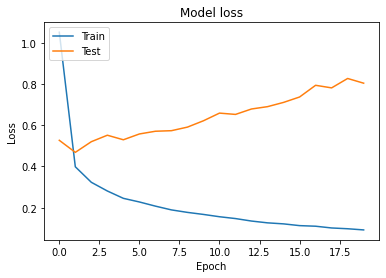

In [ ]:
#Graphing Model Metrics
import matplotlib.pyplot as plt
print('hist {}'.format(hist.history))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
transfer_model.load_weights('/dog-images/My Drive/dog-images/weights.best.'+pmodel+ '.hdf5')

In [ ]:
# get index of predicted dog breed for each image in test set
transfer_predictions = [np.argmax(transfer_model.predict(np.expand_dims(feature, axis=0))) for feature in test_transfer]
new_test_targets = test_targets[:, 1:len(test_targets)-1]
# report test accuracy
test_accuracy = 100*np.sum(np.array(transfer_predictions)==np.argmax(new_test_targets, axis=1))/len(transfer_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.9713%


# Step 4: Using predefined Xception modelep

In [ ]:

from keras.applications import Xception
from keras.applications import imagenet_utils

In [ ]:
import sys
import os
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


seed = 9
np.random.seed(seed=seed)
#tf.set_random_seed(seed=seed)
tf.random.set_seed(seed=seed)
# hyper parameters for model
nb_classes = 133  # number of classes
based_model_last_block_layer_number = 126  # value is based on based model selected.
img_width, img_height = 224, 224 # change based on the shape/structure of your images
batch_size = 64  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 20  # number of iteration the algorithm gets trained.
learn_rate = 1e-4  # sgd learning rate
momentum = .9  # sgd momentum to avoid local minimum
transformation_ratio = .05  # how aggressive will be the data augmentation/transformation

train_data_dir = '/dog-images/My Drive/dog-images/train'
validation_data_dir = '/dog-images/My Drive/dog-images/valid'
model_path = '/dog-images/My Drive/dog-images/'


base_model = Xception(input_shape=(224,224, 3), weights='imagenet', include_top=False)
#new_model = Xception(include_top=False, weights='imagenet', input_shape=(224,224, 3), pooling=None, classes=133)

# Top Model Block
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(nb_classes, activation='softmax')(x)

# add your top layer block to your base model
new_model = Model(base_model.input, predictions)
#print(new_model.summary())

# # let's visualize layer names and layer indices to see how many layers/blocks to re-train
# # uncomment when choosing based_model_last_block_layer
#for i, layer in enumerate(new_model.layers):
#    print(i, layer.name)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all layers of the based model that is already pre-trained.
for layer in base_model.layers:
    layer.trainable = False

# Read Data and Augment it: Make sure to select augmentations that are appropriate to your images.
# To save augmentations un-comment save lines and add to your flow parameters.
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=transformation_ratio,
                                   shear_range=transformation_ratio,
                                   zoom_range=transformation_ratio,
                                   cval=transformation_ratio,
                                   horizontal_flip=True,
                                   vertical_flip=True)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

os.makedirs(os.path.join(os.path.abspath(train_data_dir), '../preview'), exist_ok=True)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
                                                    #save_to_dir=os.path.join(os.path.abspath(train_data_dir), '../preview'),
                                                    #save_prefix='aug',
                                                    #save_format='jpeg')
# use the above 3 commented lines if you want to save and look at how the data augmentations look like

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size=(224,224),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

new_model.compile(optimizer='nadam',
                  loss='categorical_crossentropy',  # categorical_crossentropy if multi-class classifier
                  metrics=['accuracy'])

# save weights of best training epoch: monitor either val_loss or val_acc

top_weights_path = os.path.join(os.path.abspath(model_path), 'top_model_weights.h5')
callbacks_list = [
                  ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
                  EarlyStopping(monitor='val_acc', patience=5, verbose=0)
                ]


# Train Simple CNN
hist = new_model.fit_generator(train_generator,
                    samples_per_epoch=train_generator.samples,
                    nb_epoch=nb_epoch / 5,
                    validation_data=validation_generator,
                    nb_val_samples=validation_generator.samples,
                    callbacks=callbacks_list)




83689472/83683744 [==============================] - 1s 0us/step
Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=104, epochs=4.0, validation_steps=835)`


Epoch 1/4
104/104 [==============================] - 599s 6s/step - loss: 3.3398 - accuracy: 0.3541 - val_loss: 0.6077 - val_accuracy: 0.7606
Epoch 2/4


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


104/104 [==============================] - 596s 6s/step - loss: 1.9403 - accuracy: 0.5751 - val_loss: 0.6129 - val_accuracy: 0.8037
Epoch 3/4
104/104 [==============================] - 595s 6s/step - loss: 1.5542 - accuracy: 0.6480 - val_loss: 0.5972 - val_accuracy: 0.8132
Epoch 4/4
104/104 [==============================] - 586s 6s/step - loss: 1.3358 - accuracy: 0.6909 - val_loss: 0.7731 - val_accuracy: 0.8166


In [ ]:
# verbose
print("\nStarting to Fine Tune Model\n")

# add the best weights from the train top model
# at this point we have the pre-train weights of the base model and the trained weight of the new/added top model
# we re-load model weights to ensure the best epoch is selected and not the last one.
new_model.load_weights(top_weights_path)

# based_model_last_block_layer_number points to the layer in your model you want to train.
# For example if you want to train the last block of a 19 layer VGG16 model this should be 15
# If you want to train the last Two blocks of an Inception model it should be 172
# layers before this number will used the pre-trained weights, layers above and including this number
# will be re-trained based on the new data.
for layer in new_model.layers[:based_model_last_block_layer_number]:
      layer.trainable = False
for layer in new_model.layers[based_model_last_block_layer_number:]:
      layer.trainable = True

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
new_model.compile(optimizer='nadam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# save weights of best training epoch: monitor either val_loss or val_acc
final_weights_path = os.path.join(os.path.abspath(model_path), 'model_weights.h5')
callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, verbose=0)
]

# fine-tune the model
hist1 = new_model.fit_generator(train_generator,
                        samples_per_epoch=train_generator.samples,
                        nb_epoch=nb_epoch,
                        validation_data=validation_generator,
                        nb_val_samples=validation_generator.samples,
                        callbacks=callbacks_list)

# save model
new_model_json = new_model.to_json()
with open(os.path.join(os.path.abspath(model_path), 'model.json'), 'w') as json_file:
        json_file.write(new_model_json)




Starting to Fine Tune Model



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=104, epochs=20, validation_steps=835)`


Epoch 1/20
104/104 [==============================] - 572s 5s/step - loss: 1.3172 - accuracy: 0.6236 - val_loss: 1.5744 - val_accuracy: 0.7115
Epoch 2/20


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


104/104 [==============================] - 567s 5s/step - loss: 0.8842 - accuracy: 0.7468 - val_loss: 1.5256 - val_accuracy: 0.7269
Epoch 3/20
104/104 [==============================] - 556s 5s/step - loss: 0.6451 - accuracy: 0.8050 - val_loss: 1.3164 - val_accuracy: 0.7460
Epoch 4/20
104/104 [==============================] - 559s 5s/step - loss: 0.4918 - accuracy: 0.8495 - val_loss: 1.3143 - val_accuracy: 0.7484
Epoch 5/20
104/104 [==============================] - 564s 5s/step - loss: 0.3848 - accuracy: 0.8827 - val_loss: 0.9300 - val_accuracy: 0.7306
Epoch 6/20
104/104 [==============================] - 564s 5s/step - loss: 0.3466 - accuracy: 0.8974 - val_loss: 1.6825 - val_accuracy: 0.7366
Epoch 7/20
104/104 [==============================] - 572s 6s/step - loss: 0.2937 - accuracy: 0.9063 - val_loss: 1.0681 - val_accuracy: 0.7688
Epoch 8/20
104/104 [==============================] - 572s 5s/step - loss: 0.2289 - accuracy: 0.9282 - val_loss: 0.8686 - val_accuracy: 0.7581
Epoch 9/20

hist {'val_loss': [0.6076629757881165, 0.6128911375999451, 0.5971875190734863, 0.7731183767318726], 'val_accuracy': [0.7605786323547363, 0.803676187992096, 0.8132461309432983, 0.8166130781173706], 'loss': [3.334990367635706, 1.9420065927390175, 1.5530920674463569, 1.3358310564829907], 'accuracy': [0.35414147, 0.5751209, 0.6479746, 0.69090086]}
hist1{'val_loss': [1.5743818283081055, 1.5256317853927612, 1.3164325952529907, 1.314255952835083, 0.9299708008766174, 1.6825284957885742, 1.0680609941482544, 0.868567943572998, 0.8479585647583008, 0.7722625732421875, 1.073968768119812, 1.660409688949585, 0.8438321352005005, 0.07321097701787949, 2.063096761703491, 0.8640435934066772, 0.9756919145584106, 1.212235450744629, 0.7938623428344727], 'val_accuracy': [0.7114624381065369, 0.7268581986427307, 0.7460123300552368, 0.7484130263328552, 0.7305745482444763, 0.736582338809967, 0.7687826156616211, 0.7580554485321045, 0.7675809264183044, 0.7628364562988281, 0.7750502228736877, 0.7449690103530884, 0.7

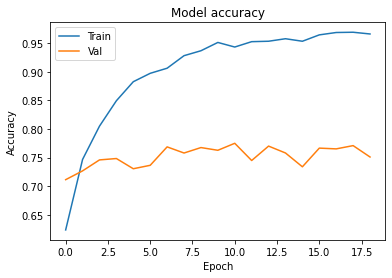

In [ ]:
#Graphing Model Metrics
import matplotlib.pyplot as pyplot
print('hist {}'.format(hist.history))
print('hist1{}'.format(hist1.history))

pyplot.plot(hist1.history['accuracy'])
pyplot.plot(hist1.history['val_accuracy'])
pyplot.title('Model accuracy')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Val'], loc='upper left')
pyplot.show()

In [ ]:



new_model.load_weights('/dog-images/My Drive/dog-images/model_weights.h5')
test_data_dir = '/dog-images/My Drive/dog-images/test'

test_generator = validation_datagen.flow_from_directory(test_data_dir,
                                                        target_size=(224,224),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')
# get index of predicted dog breed for each image in test set
#test_predictions = [np.argmax(new_model.predict(np.expand_dims(feature, axis=0))) for feature in test_generator]

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=new_model.predict_generator(test_generator,
                                 steps=STEP_SIZE_TEST,
                                 verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
#print(predicted_class_indices.shape())

# report test accuracy
test_accuracy = 100*np.sum(np.array(predicted_class_indices)==np.argmax(test_generator.samples, axis=0))/len(predicted_class_indices)
print('Test accuracy: %.4f%%' % test_accuracy)




Found 836 images belonging to 133 classes.
13/13 [==============================] - 8s 578ms/step
Test accuracy: 0.6010%


---
<a id='step6'></a>
## Step 5: Test Algorithm

What kind of dog does the algorithm think that it looks like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?


In [ ]:
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.applications.xception import preprocess_input, decode_predictions
dog_names = [item[42:-1] for item in sorted(glob("/dog-images/My Drive/dog-images/train/*/"))]
print ("dog_names {}".format(dog_names))
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def Inc_predict_breed(img_path):
    # extract bottleneck features
    img = preprocess_input(path_to_tensor(img_path))
    predicted_vector = new_model.predict(img)
    #print ("predicted_vector: {}".format(np.argmax(predicted_vector)))
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

dog_names ['Affenpinscher', 'Afghan_hound', 'Airedale_terrier', 'Akita', 'Alaskan_malamute', 'American_eskimo_dog', 'American_foxhound', 'American_staffordshire_terrier', 'American_water_spaniel', 'Anatolian_shepherd_dog', 'Australian_cattle_dog', 'Australian_shepherd', 'Australian_terrier', 'Basenji', 'Basset_hound', 'Beagle', 'Bearded_collie', 'Beauceron', 'Bedlington_terrier', 'Belgian_malinois', 'Belgian_sheepdog', 'Belgian_tervuren', 'Bernese_mountain_dog', 'Bichon_frise', 'Black_and_tan_coonhound', 'Black_russian_terrier', 'Bloodhound', 'Bluetick_coonhound', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_terrier', 'Bouvier_des_flandres', 'Boxer', 'Boykin_spaniel', 'Briard', 'Brittany', 'Brussels_griffon', 'Bull_terrier', 'Bulldog', 'Bullmastiff', 'Cairn_terrier', 'Canaan_dog', 'Cane_corso', 'Cardigan_welsh_corgi', 'Cavalier_king_charles_spaniel', 'Chesapeake_bay_retriever', 'Chihuahua', 'Chinese_crested', 'Chinese_shar-pei', 'Chow_chow', 'Clumber_spaniel', 'Cocker_spaniel',

In [ ]:
from matplotlib import pyplot as plt 
  
def predict_breed_or_resemblance(img_path):
    creature = None
    message = None
    breed = None
    #if dog_detector(img_path):
    #    creature = "dog"
    #    message = "your predicted breed is"
    
    #if face_detector(img_path):
    #    creature = "human"
    #    message = "you look like a"
    
    #if not creature:
    #    raise NeitherDogNorHumanError("Tis neither a dog nor a human!!!")
    # creating a object  
    plt.show(img_path)  
    
    breed = Inc_predict_breed(img_path)
    return "Hello,  {}".format(breed)

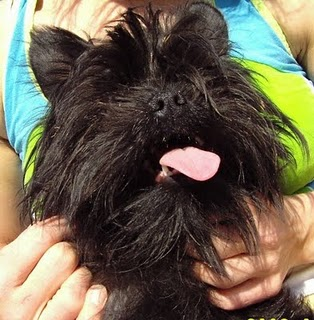

Hello,  Affenpinscher
I am Affenpinscher


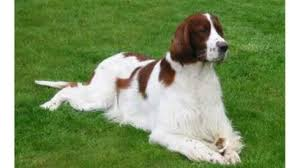

Hello,  Irish_red_and_white_setter
I am Irish Red and White Setter


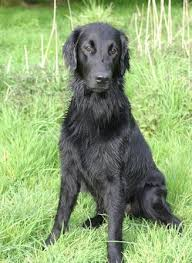

Hello,  Flat-coated_retriever
I am Flat Coated Retriver


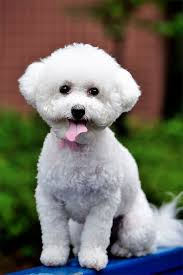

Hello,  Bichon_frise
I am Bichon Frise


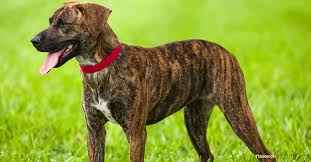

Hello,  Greyhound
I am Plott


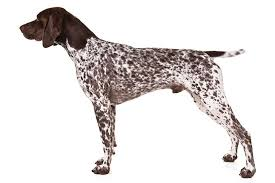

Hello,  German_shorthaired_pointer
I am Pointer


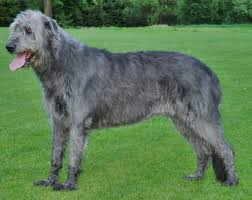

Hello,  Irish_wolfhound
I am Irish Wolfhound


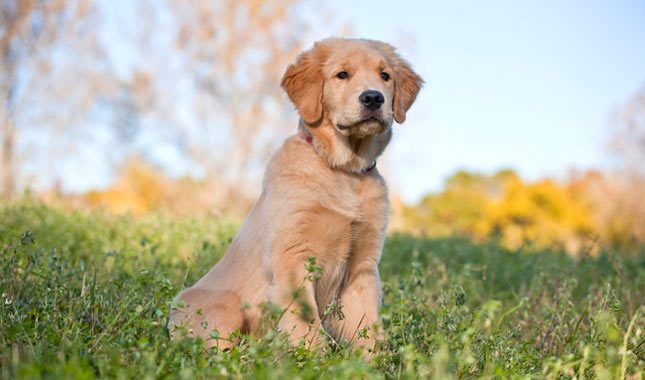

Hello,  Golden_retriever
I am Golden Retriever


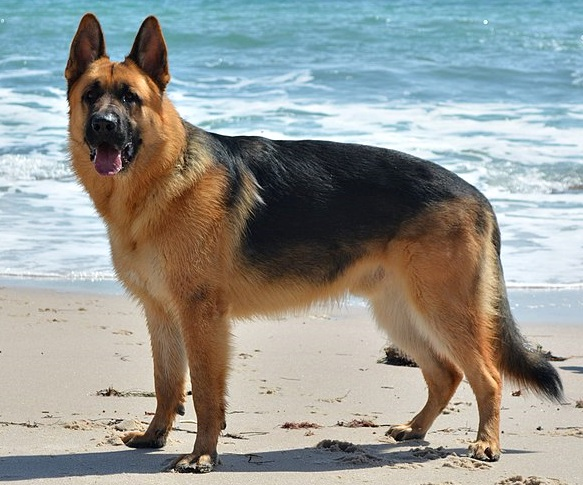

Hello,  German_shepherd_dog
I am German Shepard


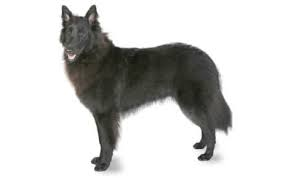

Hello,  Belgian_sheepdog
I am Belgian Sheepdog


In [ ]:
from IPython.display import Image, display
display(Image(filename="/dog-images/My Drive/dog-images/test/001.Affenpinscher/Affenpinscher_00003.jpg"))

print(predict_breed_or_resemblance("/dog-images/My Drive/dog-images/test/001.Affenpinscher/Affenpinscher_00003.jpg"))
print("I am Affenpinscher")


display(Image(filename='/dog-images/My Drive/dog-images/Irish_Red_and_White_Setter_testthing.jpg'))
print(predict_breed_or_resemblance("/dog-images/My Drive/dog-images/Irish_Red_and_White_Setter_testthing.jpg"))
print("I am Irish Red and White Setter")

display(Image(filename='/dog-images/My Drive/dog-images/Flat_Coated_Retriver_Testthing.jpg'))
print(predict_breed_or_resemblance("/dog-images/My Drive/dog-images/Flat_Coated_Retriver_Testthing.jpg"))
print("I am Flat Coated Retriver")

display(Image(filename='/dog-images/My Drive/dog-images/Bichon_Frise_Testthing.jpg'))
print(predict_breed_or_resemblance("/dog-images/My Drive/dog-images/Bichon_Frise_Testthing.jpg"))
print("I am Bichon Frise")

display(Image(filename='/dog-images/My Drive/dog-images/plott.jpeg'))
print(predict_breed_or_resemblance('/dog-images/My Drive/dog-images/plott.jpeg'))
print("I am Plott")

display(Image(filename='/dog-images/My Drive/dog-images/pointer.jpeg'))
print(predict_breed_or_resemblance('/dog-images/My Drive/dog-images/pointer.jpeg'))
print("I am Pointer")

display(Image(filename='/dog-images/My Drive/dog-images/irish wolfhound.jpeg'))
print(predict_breed_or_resemblance('/dog-images/My Drive/dog-images/irish wolfhound.jpeg'))
print("I am Irish Wolfhound")

display(Image(filename='/dog-images/My Drive/dog-images/golden retriver.jpeg'))
print(predict_breed_or_resemblance('/dog-images/My Drive/dog-images/golden retriver.jpeg'))
print("I am Golden Retriever")


display(Image(filename='/dog-images/My Drive/dog-images/german shepard.jpg'))
print(predict_breed_or_resemblance('/dog-images/My Drive/dog-images/german shepard.jpg'))
print("I am German Shepard")

display(Image(filename='/dog-images/My Drive/dog-images/belgian sheepdog.jpeg'))
print(predict_breed_or_resemblance('/dog-images/My Drive/dog-images/belgian sheepdog.jpeg'))
print("I am Belgian Sheepdog")





              
